# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science: 
## Homework 4 - Regularization 



**Harvard University**<br/>
**Fall 2018**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader

<hr style="height:2pt">

### INSTRUCTIONS

- **This homework must be completed individually.**

- To submit your assignment follow the instructions given in Canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- As much as possible, try and stick to the hints and functions we import at the top of the homework, as those are the ideas and tools the class supports and is aiming to teach. And if a problem specifies a particular library you're required to use that library, and possibly others from the import list.


Names of people you have worked with goes here: 

<hr style="height:2pt">

In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

import these libraries

In [2]:
import warnings
#warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold

import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS

import warnings

warnings.filterwarnings('ignore')
from pandas.core import datetools
%matplotlib inline

# Continuing Bike Sharing Usage Data

In this homework, we will focus on regularization and cross validation. We will continue to build regression models for the [Capital Bikeshare program](https://www.capitalbikeshare.com) in Washington D.C.  See homework 3 for more information about the Capital Bikeshare data that we'll be using extensively. 



<div class='exercise'> <b> Question 1 [20pts]  Data pre-processing </b> </div>

**1.1** Read in the provided `bikes_student.csv` to a data frame named `bikes_main`. Split it into a training set `bikes_train` and a validation set `bikes_val`. Use `random_state=90`, a test set size of .2, and stratify on month. Remember to specify the data's index column as you read it in.

**1.2** As with last homework, the response will be the `counts` column and we'll drop `counts`, `registered` and `casual` for being trivial predictors, drop `workingday` and `month` for being multicollinear with other columns, and `dteday` for being inappropriate for regression. Write code to do this.

Encapsulate this process as a function with appropriate inputs and outputs, and **test** your code by producing `practice_y_train` and `practice_X_train`.

**1.3** Write a function to standardize a provided subset of columns in your training/validation/test sets. Remember that while you will be scaling all of your data, you must learn the scaling parameters (mean and SD) from only the training set.

Test your code by building a list of all non-binary columns in your `practice_X_train` and scaling only those columns. Call the result `practice_X_train_scaled`. Display the `.describe()` and verify that you have correctly scaled all columns, including the polynomial columns.

**Hint: employ the provided list of binary columns and use `pd.columns.difference()`**

`binary_columns = [ 'holiday', 'workingday','Feb', 'Mar', 'Apr',
       'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'spring',
       'summer', 'fall', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat',
       'Cloudy', 'Snow', 'Storm']`


**1.4** Write a code to augment your a dataset with higher-order features for `temp`, `atemp`, `hum`,`windspeed`, and `hour`. You should include ONLY the pure powers of these columns. So with degree=2 you should produce `atemp^2` and `hum^2` but not `atemp*hum` or any other two-feature interactions. 


Encapsulate this process as a function with appropriate inputs and outputs, and test your code by producing `practice_X_train_poly`, a training dataset with quadratic and cubic features built from `practice_X_train_scaled`, and printing `practice_X_train_poly`'s column names and `.head()`.

**1.5** Write code to add interaction terms to the model. Specifically, we want interactions between the continuous predictors (`temp`,`atemp`, `hum`,`windspeed`) and the month and weekday dummies (`Feb`, `Mar`...`Dec`, `Mon`, `Tue`, ... `Sat`). That means you SHOULD build `atemp*Feb` and `hum*Mon` and so on, but NOT `Feb*Mar` and NOT `Feb*Tue`. The interaction terms should always be a continuous feature times a month dummy or a continuous feature times a weekday dummy.


Encapsulate this process as a function with appropriate inputs and outputs, and test your code by adding interaction terms to `practice_X_train_poly` and show its column names and `.head()`**

**1.6** Combine all your code so far into a function that takes in `bikes_train`, `bikes_val`, the names of columns for polynomial, the target column, the columns to be dropped and produces computation-ready design matrices `X_train` and `X_val` and responses `y_train` and `y_val`. Your final function should build correct, scaled design matrices with the stated interaction terms and any polynomial degree.



### Solutions 

**1.1** Read in the provided `bikes_student.csv` to a data frame named `bikes_main`. Split it into a training set `bikes_train` and a validation set `bikes_val`. Use `random_state=90`, a test set size of .2, and stratify on month. Remember to specify the data's index column as you read it in.

In [3]:
# your code here
bikes_main=pd.read_csv('data/bikes_student.csv',index_col=0)
bikes_train,bikes_val=train_test_split(bikes_main,random_state=90,
                                       test_size=0.2,stratify=bikes_main.month)
bikes_train.head()

,dteday,hour,year,holiday,workingday,temp,atemp,hum,windspeed,casual,...,Mon,Tue,Wed,Thu,Fri,Sat,Cloudy,Snow,Storm,month
15762,2012-10-23,23,1,0,1,0.54,0.5152,0.73,0.1045,9,...,0,1,0,0,0,0,0,0,0,10
4213,2011-06-29,11,0,0,1,0.76,0.6667,0.35,0.2239,53,...,0,0,1,0,0,0,0,0,0,6
14301,2012-08-24,2,1,0,1,0.66,0.6212,0.69,0.0000,1,...,0,0,0,0,1,0,0,0,0,8
15900,2012-10-31,5,1,0,1,0.30,0.3030,0.81,0.1343,0,...,0,0,1,0,0,0,1,0,0,10
14320,2012-08-24,21,1,0,1,0.70,0.6515,0.61,0.1642,58,...,0,0,0,0,1,0,1,0,0,8


**1.2** As with last homework, the response will be the `counts` column and we'll drop `counts`, `registered` and `casual` for being trivial predictors, drop `workingday` and `month` for being multicolinear with other columns, and `dteday` for being inappropriate for regression. Write code to do this.

Encapsulate this process as a function with appropriate inputs and outputs, and test your code by producing `practice_y_train` and `practice_X_train`


In [4]:
# your code here
def refine_variables(dat,target_col='',bad_columns=[]):
    df=dat.copy()
    y_train=df[target_col]
    x_train=df.drop(bad_columns,axis=1)
    return x_train,y_train

practice_X_train,practice_y_train=refine_variables(
    bikes_train,target_col='counts',bad_columns=['counts', 'registered', 'casual',
                                                 'workingday', 'month', 'dteday'])
practice_X_train.head()

,hour,year,holiday,temp,atemp,hum,windspeed,Feb,Mar,Apr,...,fall,Mon,Tue,Wed,Thu,Fri,Sat,Cloudy,Snow,Storm
15762,23,1,0,0.54,0.5152,0.73,0.1045,0,0,0,...,1,0,1,0,0,0,0,0,0,0
4213,11,0,0,0.76,0.6667,0.35,0.2239,0,0,0,...,0,0,0,1,0,0,0,0,0,0
14301,2,1,0,0.66,0.6212,0.69,0.0000,0,0,0,...,0,0,0,0,0,1,0,0,0,0
15900,5,1,0,0.30,0.3030,0.81,0.1343,0,0,0,...,1,0,0,1,0,0,0,1,0,0
14320,21,1,0,0.70,0.6515,0.61,0.1642,0,0,0,...,0,0,0,0,0,1,0,1,0,0


**1.3** Write a function to standardize a provided subset of columns in your training/validation/test sets. Remember that while you will be scaling all of your data, you must learn the scaling parameters (mean and SD) from only the training set.

Test your code by building a list of all non-binary columns in your `practice_X_train` and scaling only those columns. Call the result `practice_X_train_scaled`. Display the `.describe()` and verify that you have correctly scaled all columns, including the polynomial columns.

**Hint: employ the provided list of binary columns and use `pd.columns.difference()`**

`binary_columns = [ 'holiday', 'workingday','Feb', 'Mar', 'Apr',
       'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'spring',
       'summer', 'fall', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat',
       'Cloudy', 'Snow', 'Storm']`


In [5]:
# your code here
def scale_variables(dat):
    df=dat.copy()
    binary_columns = [ 'holiday','year','Feb', 'Mar', 'Apr',
           'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'spring',
           'summer', 'fall', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat',
           'Cloudy', 'Snow', 'Storm']
    df_scaled=df[df.columns.difference(binary_columns)].apply(lambda x: (x - np.mean(x)) / np.std(x))
    df_scaled=df_scaled.join(df[binary_columns])       
    return df_scaled

practice_X_train_scaled=scale_variables(practice_X_train)
practice_X_train_scaled.describe()

,atemp,hour,hum,temp,windspeed,holiday,year,Feb,Mar,Apr,...,fall,Mon,Tue,Wed,Thu,Fri,Sat,Cloudy,Snow,Storm
count,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.00000,1000.000000,1000.000000,1000.0
mean,4.026779e-15,-1.811190e-16,-4.013789e-15,-4.038325e-15,8.927858e-15,0.027000,0.509000,0.078000,0.085000,0.082000,...,0.248000,0.143000,0.148000,0.162000,0.128000,0.12700,0.15000,0.280000,0.082000,0.0
std,1.000500e+00,1.000500e+00,1.000500e+00,1.000500e+00,1.000500e+00,0.162164,0.500169,0.268306,0.279021,0.274502,...,0.432068,0.350248,0.355278,0.368635,0.334257,0.33314,0.35725,0.449224,0.274502,0.0
min,-2.402605e+00,-1.646163e+00,-3.397602e+00,-2.347976e+00,-1.554205e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.0
25%,-8.121270e-01,-9.189949e-01,-7.421467e-01,-7.922693e-01,-7.231056e-01,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.0
50%,7.147176e-02,-4.639332e-02,5.448995e-02,3.744066e-02,-1.130295e-02,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.0
75%,8.670022e-01,8.262083e-01,8.511266e-01,8.671507e-01,4.634972e-01,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,1.000000,0.000000,0.0
max,2.546131e+00,1.698810e+00,1.913309e+00,2.319143e+00,5.211499e+00,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.00000,1.000000,1.000000,0.0


In [6]:
# your code here
def polynomial_variables(dat,degree=2,columns_forpoly=[]):
    df=dat.copy()
    df_poly_new=dat.copy()
    if degree != 1:
        for j in range (2,degree+1):
            df_poly=df[columns_forpoly].apply(lambda x: (x**j))
            df_poly.rename(columns={columns_forpoly[i]:str(columns_forpoly[i])+'_degree'+str(j) 
                                for i in range (0,len(columns_forpoly))}, inplace = True)
            df_poly_new=df_poly_new.join(df_poly)
    return df_poly_new
practice_X_train_poly=polynomial_variables(practice_X_train_scaled,
                                           2,columns_forpoly=['temp', 'atemp', 'hum','windspeed', 'hour'])
practice_X_train_poly.head()

,atemp,hour,hum,temp,windspeed,holiday,year,Feb,Mar,Apr,...,Fri,Sat,Cloudy,Snow,Storm,temp_degree2,atemp_degree2,hum_degree2,windspeed_degree2,hour_degree2
15762,0.248775,1.698810,0.479363,0.244868,-0.723106,0,1,0,0,0,...,0,0,0,0,0,0.059960,0.061889,0.229789,0.522882,2.885955
4213,1.132373,-0.046393,-1.538783,1.385719,0.226495,0,0,0,0,0,...,0,0,0,0,0,1.920218,1.282270,2.367854,0.051300,0.002152
14301,0.867002,-1.355296,0.266926,0.867151,-1.554205,0,1,0,0,0,...,1,0,0,0,0,0.751950,0.751693,0.071250,2.415552,1.836827
15900,-0.988847,-0.918995,0.904236,-0.999697,-0.486103,0,1,0,0,0,...,0,0,1,0,0,0.999394,0.977818,0.817642,0.236296,0.844552
14320,1.043722,1.407943,-0.157946,1.074578,-0.248305,0,1,0,0,0,...,1,0,1,0,0,1.154718,1.089356,0.024947,0.061656,1.982303


**1.5** Write code to add interaction terms to the model. Specifically, we want interactions between the continuous predictors (`temp`,`atemp`, `hum`,`windspeed`) and the month and weekday dummies (`Feb`, `Mar`...`Dec`, `Mon`, `Tue`, ... `Sat`). That means you SHOULD build `atemp*Feb` and `hum*Mon` and so on, but NOT `Feb*Mar` and NOT `Feb*Tue`. The interaction terms should always be a continuous feature times a month dummy or a continuous feature times a weekday dummy.


Encapsulate this process as a function with appropriate inputs and outputs, and test your code by adding interaction terms to `practice_X_train_poly` and show its column names and `.head()`**


In [7]:
# your code here
def interact_variables(dat):
    df=dat.copy()
    continuous_predictors=('temp','atemp', 'hum','windspeed')
    dummies=('Feb','Mar','Apr','May','Jun','Jul','Aug','Sept',
             'Oct','Nov','Dec','Mon','Tue','Wed','Thu','Fri','Sat')
    for k in continuous_predictors:
        for i in dummies:
            col_name=str(k + '*'+ i)
            col_new=df[k]*df[i]
            df[col_name]=col_new
    return df

practice_X_train_poly_interact=interact_variables(practice_X_train_poly)
practice_X_train_poly_interact.head()                    

,atemp,hour,hum,temp,windspeed,holiday,year,Feb,Mar,Apr,...,windspeed*Sept,windspeed*Oct,windspeed*Nov,windspeed*Dec,windspeed*Mon,windspeed*Tue,windspeed*Wed,windspeed*Thu,windspeed*Fri,windspeed*Sat
15762,0.248775,1.698810,0.479363,0.244868,-0.723106,0,1,0,0,0,...,-0.0,-0.723106,-0.0,-0.0,-0.0,-0.723106,-0.000000,-0.0,-0.000000,-0.0
4213,1.132373,-0.046393,-1.538783,1.385719,0.226495,0,0,0,0,0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.226495,0.0,0.000000,0.0
14301,0.867002,-1.355296,0.266926,0.867151,-1.554205,0,1,0,0,0,...,-0.0,-0.000000,-0.0,-0.0,-0.0,-0.000000,-0.000000,-0.0,-1.554205,-0.0
15900,-0.988847,-0.918995,0.904236,-0.999697,-0.486103,0,1,0,0,0,...,-0.0,-0.486103,-0.0,-0.0,-0.0,-0.000000,-0.486103,-0.0,-0.000000,-0.0
14320,1.043722,1.407943,-0.157946,1.074578,-0.248305,0,1,0,0,0,...,-0.0,-0.000000,-0.0,-0.0,-0.0,-0.000000,-0.000000,-0.0,-0.248305,-0.0


**1.6** Combine all your code so far into a function that takes in `bikes_train`, `bikes_val`, the names of columns for polynomial, the target column, the columns to be dropped and produces computation-ready design matrices `X_train` and `X_val` and responses `y_train` and `y_val`. Your final function should build correct, scaled design matrices with the stated interaction terms and any polynomial degree.

In [8]:
def get_design_mats(train_df, val_df,  degree, 
                    columns_forpoly=['temp', 'atemp', 'hum','windspeed', 'hour'],
                    target_col='counts', 
                    bad_columns=['counts', 'registered', 'casual', 'workingday', 'month', 'dteday']):
    
    x_train,y_train=refine_variables(train_df,target_col,bad_columns)
    x_train_2=scale_variables(x_train)
    x_train_3=polynomial_variables(x_train_2,degree,columns_forpoly)
    x_train_4=interact_variables(x_train_3)
    
    binary_columns = [ 'holiday','year','Feb', 'Mar', 'Apr',
        'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'spring',
        'summer', 'fall', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat',
        'Cloudy', 'Snow', 'Storm']
    x_val,y_val=refine_variables(val_df,target_col,bad_columns)
    train_mean=np.mean(x_train[x_train.columns.difference(binary_columns)])
    train_std=np.std(x_train[x_train.columns.difference(binary_columns)])
     
    x_val_scaled=x_val[x_val.columns.difference(binary_columns)]
    for i in x_val_scaled.columns.values.tolist():
        x_val_scaled[i]=(x_val_scaled[i]- train_mean[i]) / train_std[i]
        x_val_2=x_val_scaled.join(x_val[binary_columns]) 
        
    x_val_3=polynomial_variables(x_val_2,degree,columns_forpoly)
    x_val_4=interact_variables(x_val_3)
    # add code here 
    return x_train_4,y_train, x_val_4,y_val


In [9]:
# your code here
X_train,y_train,X_val,y_val=get_design_mats(bikes_train,bikes_val,2)
X_val.describe()

,atemp,hour,hum,temp,windspeed,holiday,year,Feb,Mar,Apr,...,windspeed*Sept,windspeed*Oct,windspeed*Nov,windspeed*Dec,windspeed*Mon,windspeed*Tue,windspeed*Wed,windspeed*Thu,windspeed*Fri,windspeed*Sat
count,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.00000,250.000000,250.000000,...,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000
mean,0.030762,0.066463,-0.034521,0.035781,0.074947,0.044000,0.536000,0.07600,0.084000,0.084000,...,0.003352,-0.023718,-0.014692,0.020918,0.018963,0.032439,-0.004730,-0.002445,0.010335,0.025519
std,1.006891,1.005123,0.996533,0.991393,0.922962,0.205507,0.499703,0.26553,0.277944,0.277944,...,0.226063,0.264793,0.292966,0.304081,0.363190,0.357898,0.313457,0.327324,0.337981,0.388775
min,-2.402605,-1.646163,-3.397602,-2.140548,-1.554205,0.000000,0.000000,0.00000,0.000000,0.000000,...,-1.554205,-1.554205,-1.554205,-1.554205,-1.554205,-1.554205,-1.554205,-1.554205,-1.554205,-1.554205
25%,-0.812127,-0.773561,-0.795256,-0.792269,-0.723106,0.000000,0.000000,0.00000,0.000000,0.000000,...,-0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000
50%,0.160123,0.099040,-0.051728,0.141154,-0.011303,0.000000,1.000000,0.00000,0.000000,0.000000,...,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000
75%,0.867002,0.971642,0.784740,0.867151,0.701295,0.000000,1.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000
max,2.192692,1.698810,1.913309,2.111716,3.075296,1.000000,1.000000,1.00000,1.000000,1.000000,...,1.294596,1.532394,1.532394,2.600496,2.600496,3.075296,1.532394,2.007194,1.769397,3.075296


<div class='exercise'> <b> Question 2 [20pts]: Regularization via Ridge </b></div>

**2.1** For each degree in 1 through 8:

1.  Build the training design matrix and validation design matrix using the function `get_design_mats` with polynomial terms up through the specified degree.

2.  Fit a regression model to the training data.

3.  Report the model's score on the validation data.

**2.2** Discuss patterns you see in the results from 2.1. Which model would you select, and why?

**2.3** Let's try regularizing our models via ridge regression. Build a table showing the validation set $R^2$ of polynomial models with degree from 1-8, regularized at the levels $\lambda = (.01, .05, .1,.5, 1, 5, 10, 50, 100)$. Do not perform cross validation at this point, simply report performance on the single validation set. 

**2.4** Find the best-scoring degree and regularization combination.

**2.5** It's time to see how well our selected model will do on future data. Read in the provided test dataset, do any required formatting, and report the best model's $R^2$ score. How does it compare to the validation set score that made us choose this model? 

**2.6** Why do you think our model's test score was quite a bit worse than its validation score? Does the test set simply contain harder examples, or is something else going on?

### Solutions 

**2.1** For each degree in 1 through 8:

1.  Build the training design matrix and validation design matrix using the function `get_design_mats` with polynomial terms up through the specified degree.

2.  Fit a regression model to the training data.

3.  Report the model's score on the validation data.

[0.33335935499388714, 0.4505712434573197, 0.4614700094304719, 0.4451172228962489, 0.47702669765839434, 0.4785358259112048, 0.5379013892009303, 0.5567008413666925]


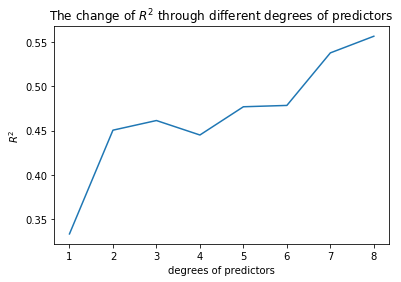

In [10]:
# your code here
r2_val=[]
for i in range(1,9):
    X_train,y_train,X_val,y_val=get_design_mats(bikes_train,bikes_val,i)
    X=sm.add_constant(X_train)
    fitted_model = OLS(endog= y_train, exog= X, hasconst=True).fit()
    X_val_predict=sm.add_constant(X_val)
    y_val_predict=fitted_model.predict(X_val_predict)
    r2_val.append(r2_score(y_val,y_val_predict))
plt.plot(np.arange(1,9),r2_val)
plt.xlabel('degrees of predictors')
plt.ylabel('$R^2$')
plt.title('The change of $R^2$ through different degrees of predictors')
print (r2_val)

**2.2** Discuss patterns you see in the results from 2.1. Which model would you select, and why?**

*your answer here*
From the patterns in results, we can see that when the polynomial degree is equal to 8, the $R^2$ reaches its maximum, thus, I will choose the model with degree 8.

**2.3** Let's try regularizing our models via ridge regression. Build a table showing the validation set $R^2$ of polynomial models with degree from 1-8, regularized at the levels $\lambda = (.01, .05, .1,.5, 1, 5, 10, 50, 100)$. Do not perform cross validation at this point, simply report performance on the single validation set. 


In [11]:
# your code here
r2_val=np.zeros((8,9))
lam=(.01,.05,.1,.5,1,5,10,50,100)
for i in range(1,9):
    X_train,y_train,X_val,y_val=get_design_mats(bikes_train,bikes_val,i)
    for j in range(0,9):
        fitted_model_ridge = Ridge(alpha=lam[j], fit_intercept=True,max_iter=100000).fit(X_train,y_train)
        y_val_predict=fitted_model_ridge.predict(X_val)
        r2_val[(i-1,j)]=(r2_score(y_val,y_val_predict))

print (r2_val)

[[0.33407957 0.33630375 0.33825457 0.34460945 0.34725678 0.35085329
  0.35066535 0.34427418 0.33717428]
 [0.45115619 0.45277952 0.4541883  0.45887709 0.46088324 0.46280097
  0.46155881 0.45277111 0.44523933]
 [0.46213385 0.4646181  0.46688297 0.47407675 0.47710513 0.483068
  0.48452226 0.47627776 0.46133068]
 [0.44581114 0.44814351 0.45026558 0.45731088 0.46049458 0.46792514
  0.47045537 0.46592534 0.45516461]
 [0.47754225 0.47942321 0.48112996 0.48658066 0.48887765 0.49358533
  0.49474462 0.49054302 0.48357254]
 [0.47900195 0.48044741 0.48185035 0.4878801  0.49154886 0.49981015
  0.5018432  0.50034574 0.49328125]
 [0.5382364  0.53878509 0.53904321 0.53755707 0.53417246 0.51838243
  0.51161274 0.49809323 0.48908204]
 [0.55688087 0.55686589 0.55631633 0.54854178 0.53996567 0.51512125
  0.50843511 0.5000184  0.49460747]]


**2.4** Find the best-scoring degree and regularization combination.

In [12]:
# your code here
np.argmax(r2_val)

print ('the best-scoring degree is 8, and the regularization value is 0.01')

the best-scoring degree is 8, and the regularization value is 0.01


**2.5** It's time to see how well our selected model will do on future data. Read in the provided test dataset `data/bikes_test.csv`, do any required formatting, and report the best model's $R^2$ score. How does it compare to the validation set score that made us choose this model? 

In [13]:
# your code here
bikes_test=pd.read_csv('data/bikes_test.csv',index_col=0)
X_train,y_train,X_test,y_test=get_design_mats(bikes_train,bikes_test,8)
X_test.describe()

,atemp,hour,hum,temp,windspeed,holiday,year,Feb,Mar,Apr,...,windspeed*Sept,windspeed*Oct,windspeed*Nov,windspeed*Dec,windspeed*Mon,windspeed*Tue,windspeed*Wed,windspeed*Thu,windspeed*Fri,windspeed*Sat
count,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.00000,1250.000000,1250.000000,1250.000000,1250.000000,...,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000
mean,0.015271,0.019110,-0.095320,0.023336,-0.033525,0.02400,0.487200,0.077600,0.084800,0.082400,...,-0.020945,-0.015731,-0.006983,-0.009489,0.000601,0.005073,-0.018768,0.000245,-0.013579,-0.000557
std,1.008668,1.015907,1.016639,1.014838,0.981929,0.15311,0.500036,0.267648,0.278695,0.275083,...,0.237027,0.275039,0.270295,0.278181,0.394413,0.373729,0.389545,0.402507,0.348281,0.375917
min,-2.579324,-1.646163,-3.397602,-2.347976,-1.554205,0.00000,0.000000,0.000000,0.000000,0.000000,...,-1.554205,-1.554205,-1.554205,-1.554205,-1.554205,-1.554205,-1.554205,-1.554205,-1.554205,-1.554205
25%,-0.812127,-0.773561,-0.848365,-0.792269,-0.723106,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000
50%,0.071472,0.099040,-0.104837,0.037441,-0.248305,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000
75%,0.867002,0.826208,0.744908,0.867151,0.463497,0.00000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2.369412,1.698810,1.913309,2.422857,4.381195,1.00000,1.000000,1.000000,1.000000,1.000000,...,1.532394,2.362698,2.362698,2.600496,3.906395,2.600496,2.837498,2.600496,4.381195,3.668597


In [14]:
# your code here
fitted_model_ridge = Ridge(alpha=0.01, fit_intercept=True,max_iter=100000).fit(X_train,y_train)
y_test_predict=fitted_model_ridge.predict(X_test)
print ('The R^2 of selected model on the test set is ' + str(r2_score(y_test,y_test_predict))
       +', which is larger than the validation set score that used for chosed model.')

The R^2 of selected model on the test set is 0.5668969429657427, which is larger than the validation set score that used for chosed model.


**2.6** Why do you think our model's test score was quite a bit worse than its validation score? Does the test set simply contain harder examples, or is something else going on?

In [15]:
# your code here


*your answer here*
As my result shows, the r-square of test set is very similar to the r-square of validation set. This means that my regression model fit the test data in a reasonable way, there is no overfitted or underfitted. Due to the population of test set may be different from the population of train and validation set, using only one train set and validation set to fit model may lead the final model not fit the test set well, which can cause the r-square of test set much differ from the validation set. Thus, we can use the cross-validation method to ensure that the train set and validation set correctly describe the whole data distribution.

<div class='exercise'><b> Question 3 [20pts]: Comparing Ridge, Lasso, and OLS </b> </div>

**3.1** Build a dataset with polynomial degree 1 and fit an OLS model, a Ridge model, and a Lasso model. Use `RidgeCV` and `LassoCV` to select the best regularization level from among `(.1,.5,1,5,10,50,100)`. 

Note: On the lasso model, you will need to increase `max_iter` to 100,000 for the optimization to converge.

**3.2** Plot histograms of the coefficients found by each of OLS, ridge, and lasso. What trends do you see in the magnitude of the coefficients?

**3.3** The plots above show the overall distribution of coefficient values in each model, but do not show how each model treats individual coefficients. Build a plot which cleanly presents, for each feature in the data, 1) The coefficient assigned by OLS, 2) the coefficient assigned by ridge, and 3) the coefficient assigned by lasso.

**Hint: Bar plots are a possible choice, but you are not required to use them**

**Hint: use `xticks` to label coefficients with their feature names**

**3.4** What trends do you see in the plot above? How do the three approaches handle the correlated pair `temp` and `atemp`?

### Solutions

**3.1** Build a dataset with polynomial degree 1 and fit an OLS model, a Ridge model, and a Lasso model. Use `RidgeCV` and `LassoCV` to select the best regularization level from among `(.1,.5,1,5,10,50,100)`. 

Note: On the lasso model, you will need to increase `max_iter` to 100,000 for the optimization to converge.

In [15]:
#your code here
X_train,y_train,X_val,y_val=get_design_mats(bikes_train,bikes_val,1)
fitted_model_OLS = LinearRegression().fit(X_train,y_train)

fitted_model_lasso=LassoCV(alphas=[0.1,0.5,1,5,10,50,100], max_iter=100000).fit(X_train,y_train)
fitted_model_ridge=RidgeCV(alphas=[0.1,0.5,1,5,10,50,100]).fit(X_train,y_train)

print ('The R-square of OLS model is '+ str(fitted_model_OLS.score(X_train,y_train))+', the R-sqaure of Lasso model is '+str(fitted_model_lasso.score(X_train,y_train))
       +', and The R-square of Ridge model is '+str(fitted_model_ridge.score(X_train,y_train))+'.')

The R-square of OLS model is 0.4849966840692576, the R-sqaure of Lasso model is 0.45132369357568747, and The R-square of Ridge model is 0.4543387997332923.



**3.2** Plot histograms of the coefficients found by each of OLS, ridge, and lasso. What trends do you see in the magnitude of the coefficients?

Text(0.5,1,'Coefficient values of selected Ridge model')

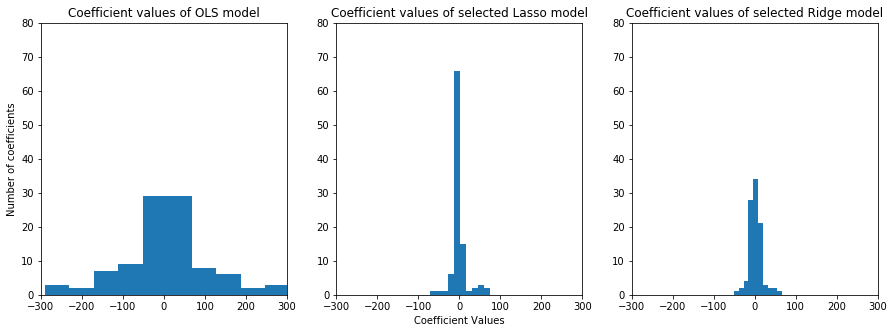

In [16]:
# your code here
plt.figure(1,figsize=(15,5))
plt.subplot(1,3,1)
plt.hist(fitted_model_OLS.coef_.ravel())
plt.xlim(-300,300)
plt.ylim(0,80)
plt.title('Coefficient values of OLS model')
plt.ylabel('Number of coefficients')
plt.subplot(1,3,2)
plt.hist(fitted_model_lasso.coef_.ravel())
plt.xlim(-300,300)
plt.ylim(0,80)
plt.title('Coefficient values of selected Lasso model')
plt.xlabel('Coefficient Values')
plt.subplot(1,3,3)
plt.hist(fitted_model_ridge.coef_.ravel())
plt.xlim(-300,300)
plt.ylim(0,80)
plt.title('Coefficient values of selected Ridge model')

*your answer here*
We can see from histograms that there are a lot of coeffificents with value 0 in all three models, however, the Lasso model have most number of coefficients equal to 0. Also, we can see that the OLS model has the largest max coefficient and smallest min coefficient cross all three models. The maximum and minimum Coefficients of lasso model is not very extreme, but there are still some coefficients whose absolute value are close to 100. Coefficients of ridge model are relatively concentrated, with not many 0 values and extreme values.

**3.3** The plots above show the overall distribution of coefficient values in each model, but do not show how each model treats individual coefficients. Build a plot which cleanly presents, for each feature in the data, 1) The coefficient assigned by OLS, 2) the coefficient assigned by ridge, and 3) the coefficient assigned by lasso.

**Hint: Bar plots are a possible choice, but you are not required to use them**

**Hint: use `xticks` to label coefficients with their feature names**

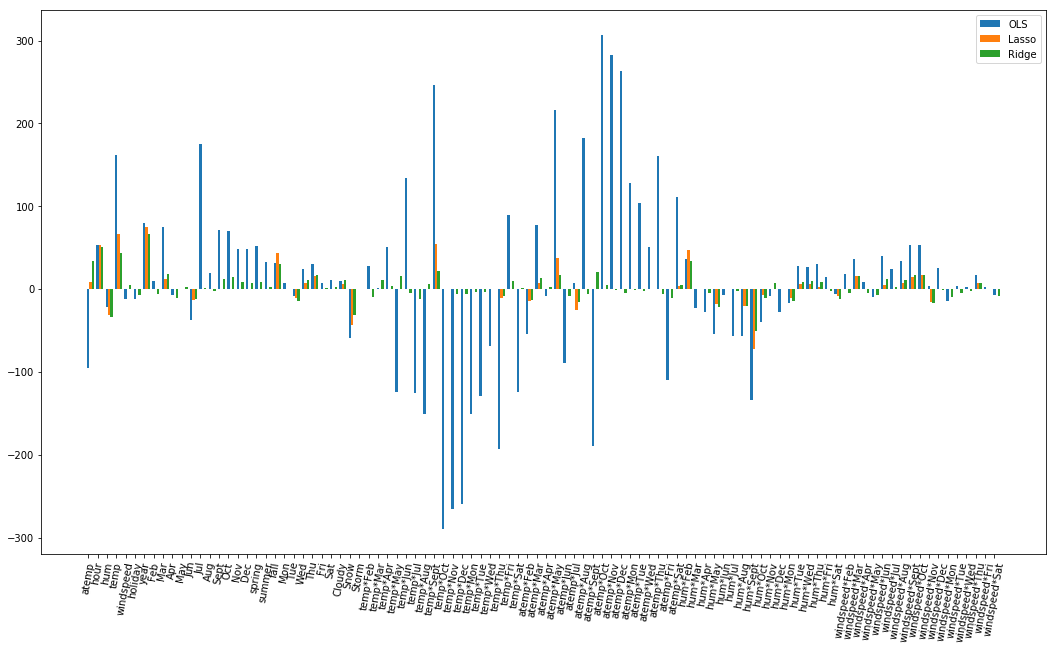

In [21]:
# your code here
x=np.arange(len(fitted_model_OLS.coef_.ravel()))+1
plt.figure(1,figsize=(18,10))
plt.bar(x,fitted_model_OLS.coef_.ravel(),width=0.25,label='OLS')
plt.bar(x+0.25,fitted_model_lasso.coef_.ravel(),width=0.25,label='Lasso')
plt.bar(x+0.5,fitted_model_ridge.coef_.ravel(),width=0.25,label='Ridge')
plt.xticks(np.arange(len(fitted_model_OLS.coef_.ravel()))+1,X_train.columns.values.tolist(), rotation=80)
plt.legend()

**3.4** What trends do you see in the plot above? How do the three approaches handle the correlated pair `temp` and `atemp`?

In [22]:
# your code here 
coef={'OLS model':(fitted_model_OLS.coef_.ravel()[0],fitted_model_OLS.coef_.ravel()[3]),
      'Lasso model':(fitted_model_lasso.coef_.ravel()[0],fitted_model_lasso.coef_.ravel()[3]),
      'Ridge model':(fitted_model_ridge.coef_.ravel()[0],fitted_model_ridge.coef_.ravel()[3])}
k=pd.DataFrame.from_dict(coef,orient='index',columns=['Atemp', 'Temp'])
k

,Atemp,Temp
OLS model,-95.858548,162.090583
Lasso model,8.776247,66.560372
Ridge model,34.203567,43.298206


*your answer here*
As we can see from the graph, the OLS model has a lot of extreme coefficients value for interaction variable such as temp\*month and atemp\*weekday, and relatively small coefficient on linear variables. However, the Lasso model has a lot of month and interaction variables with coefficients equal to 0, and no coefficients larger than 100. The ridge model doesn't contain a lot of 0 coefficient variables, but unlike OLS model, it doesn't contain extreme coefficients values with all values less than 50.
The OLS model gives the atemp extremely negative coefficient and the temp extremely positive coefficient and generated an totally positive trend combining this two variables; the Lass model nearly ignores the atemp variable by giving it a very small coefficient and gives temp a comparely large coefficient value; the Ridge model assigns atemp and temp both positive coefficients and let them explain the effect of temperature together.

<div class='exercise'> <b> Question 4 [20 pts]: Reflection </b></div>
These problems are open-ended, and you are not expected to write more than 2-3 sentences. We are interested in seeing that you have thought about these issues; you will be graded on how well you justify your conclusions here, not on what you conclude.

**4.1** Reflect back on the `get_design_mats` function you built. Writing this function useful in your analysis? What issues might you have encountered if you copy/pasted the model-building code instead of tying it together in a function? Does a `get_design_mat` function seem wise in general, or are there better options?

*your answer here*
Yes, the function is useful in my analysis. If we didn't use this function, the procedure of data processing may be different and messed up, which can generated two different design matrix for training set and validation set, and this can falsely give the wrong test score for model we build. No, it is not general enough, we may include the binary columns inside the parameter of this function to give the flexibility to adjust the columns needed to scale.

**4.2** What are the costs and benefits of applying ridge/lasso regularization to an overfit OLS model, versus setting a specific degree of polynomial or forward selecting features for the model?

*your answer here*
The ridge/lasso regualrization can ignore many variables effects and it can drop off some variables which we are interested in, thus the result of regularization may be hard to interprete; however, the ridge/lasso regularization can give us a relatively simple model with great mase and prediction for the covariate, which can make the model more efficient, comparing to forward selection or polynomial selection.

** 4.3** This pset posed a purely predictive goal: forecast ridership as accurately as possible. How important is interpretability in this context? Considering, e.g., your lasso and ridge models from Question 3, how would you react if the models predicted well, but the coefficient values didn't make sense once interpreted?

*your answer here*
The interpretability in this context is not important,since the goal is focus on prediction. Since the model predicted well with some abnormal coefficient value, I will still use this model with these coefficients since the coefficients give great prediction, and the goal is prediction, not intepretation.


**4.4** Reflect back on our original goal of helping BikeShare predict what demand will be like in the week ahead, and thus how many bikes they can bring in for maintenance. In your view, did we accomplish this goal? If yes, which model would you put into production and why? If not, which model came closest, what other analyses might you conduct, and how likely do you think they are to work

*your answer here*
No,we didn't accomplish this goal. In my opinion, the model selected by Lasso cross-validation is closet to the goal, since it uses comparely less predictors and gives a good R-square in cross validation, which suggests it will have more chance predicting the ridership well than other models. Since there still be a large variability of ridership which are not explained by the model we have without overfitting, and the model only use the linear form for the continuous predictors, we can try to run lasso and ridge cross validation on the quadratic, cubic form, and higer polynomial of the continuous predictors, wchich may give us a better prediction result comparing using only linear form of continuous predictors. I think this will increase our prediction accuracy greatly since the higher polynomial model we conducted without cross-validation has a higher r-square. 